# CSCA-5632: Project Final
## Airline Flight Search Ranker
### Project Description
The focus of this project is to build machine learning models that can rank and predict which flight options a customer will choose when presented with the flight search results. This is a group-wise ranking problem in that the target of the model is to rank the search results within each unique search session for each customer.

The dataset is provided through a Kaggle competition, hosted by the Aeroclub IT ([FlightRank 2025: Aeroclub RecSysCup](#acknowledgements)). The data is provided as a parquet file containing approximately 18 million rows of flight search results for ~33 thousand customers over a seven month period. Given the size of the dataset, the project will be broken into multiple steps, each with a specific focus.

The goal is to build a machine learning model, based on the historical data, that can rank the results of a flight search and predict based on the ranking of the search results. The model will be evaluated on a holdout set of data, and the final model will be used to rank the flight search results for the test set.

The approach for this project is to perform the final predictions by breaking the problem into two parts:

1. **Customer Clustering**: For the first part, we will use unsupervised learning to cluster the customers into groups based on profile, search, and behavioral features.
2. **Flight Ranker**: For the second part, we will use a ranking model to predict the rank of the flight search results for each customer search session, with a separate model trained for each customer segment.

The results will be evaluated using the HitRate@3 metric to compare the selected flight to the top 3 ranking search results for each search session.

$HitRate@3 = \frac{1}{|Q|} \sum_{i=1}^{|Q|} 1(rank_i \leq 3)$

Where:
* $|Q|$ is the number of searches within a search session
* $rank_i$ is the rank of the $i^{th}$ search
* $1(rank_i \leq 3)$ is 1 if the correct flight is in the top-3, 0 otherwise

### Project Setup
Instructions for setting up the project can be found in [**README.md**](./README.md)


### Project Summary
A summary of the project and steps can be found in [**README.md**](./README.md)

## Table of Contents

- [Imports](#imports)
- [Data Source](#data-source)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Customer Segmentation](#customer-segmentation)
    - [Feature Engineering](#feature-engineering)
    - [Models](#models)
    - [Model Selection](#model-selection)
- [Flight Ranking](#flight-ranking)
    - [Feature Engineering](#feature-engineering-1)
    - [Models](#models-1)
    - [Model Selection](#model-selection-1)
- [Final Results](#final-results)
- [Next Steps](#next-steps)
- [License](#license)
- [Acknowledgements](#acknowledgements)

### Imports
Import the libraries and functions needed for the project

In [1]:
import gc
import joblib
import polars as pl
import polars.selectors as cs

import matplotlib.pyplot as plt
import seaborn as sns
from polars.polars import ColumnNotFoundError
from sklearn.metrics import silhouette_score

# project functions
from src.utils import stratified_flight_count_split

%load_ext autoreload
%autoreload 2

### Dataset Source
The dataset used for this project was provided by the [FlightRank 2025: Aeroclub RecSysCup](#acknowledgements) competition on [Kaggle](https://www.kaggle.com). The dataset files are too large to maintain within the [GitHut](https://github.com/jfroggatt/aeroclub_recsys_2025) project respository, so the competition project archive is downloaded to the local working directory, '/kaggle/input/aeroclub-recsys-2025/', and the `train.parquet` file is extracted. No other files are needed from the competition project archive.

In [2]:
# load train data file
train_df = pl.read_parquet('/kaggle/input/aeroclub-recsys-2025/train.parquet')

### Exploratory Data Analysis

In this section, we will explore the flight search data set from the `train.parquet` project file.

First, let's look at the shape, examine the first 100 rows of the data.

In [3]:
print(f'train data shape: {train_df.shape}')
train_df.head()

train data shape: (18145372, 127)


Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,legs0_duration,legs0_segments0_aircraft_code,legs0_segments0_arrivalTo_airport_city_iata,legs0_segments0_arrivalTo_airport_iata,legs0_segments0_baggageAllowance_quantity,legs0_segments0_baggageAllowance_weightMeasurementType,legs0_segments0_cabinClass,legs0_segments0_departureFrom_airport_iata,legs0_segments0_duration,legs0_segments0_flightNumber,legs0_segments0_marketingCarrier_code,legs0_segments0_operatingCarrier_code,legs0_segments0_seatsAvailable,legs0_segments1_aircraft_code,legs0_segments1_arrivalTo_airport_city_iata,legs0_segments1_arrivalTo_airport_iata,legs0_segments1_baggageAllowance_quantity,legs0_segments1_baggageAllowance_weightMeasurementType,legs0_segments1_cabinClass,legs0_segments1_departureFrom_airport_iata,legs0_segments1_duration,legs0_segments1_flightNumber,legs0_segments1_marketingCarrier_code,legs0_segments1_operatingCarrier_code,legs0_segments1_seatsAvailable,legs0_segments2_aircraft_code,legs0_segments2_arrivalTo_airport_city_iata,…,legs1_segments2_baggageAllowance_weightMeasurementType,legs1_segments2_cabinClass,legs1_segments2_departureFrom_airport_iata,legs1_segments2_duration,legs1_segments2_flightNumber,legs1_segments2_marketingCarrier_code,legs1_segments2_operatingCarrier_code,legs1_segments2_seatsAvailable,legs1_segments3_aircraft_code,legs1_segments3_arrivalTo_airport_city_iata,legs1_segments3_arrivalTo_airport_iata,legs1_segments3_baggageAllowance_quantity,legs1_segments3_baggageAllowance_weightMeasurementType,legs1_segments3_cabinClass,legs1_segments3_departureFrom_airport_iata,legs1_segments3_duration,legs1_segments3_flightNumber,legs1_segments3_marketingCarrier_code,legs1_segments3_operatingCarrier_code,legs1_segments3_seatsAvailable,miniRules0_monetaryAmount,miniRules0_percentage,miniRules0_statusInfos,miniRules1_monetaryAmount,miniRules1_percentage,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice,selected,__index_level_0__
i64,bool,i64,i64,str,i64,bool,bool,str,str,str,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,str,…,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,datetime[ns],str,bool,f64,f64,i64,i64
0,true,57323,null,"""S7/SU/UT""",36,false,false,"""2024-06-15T16:20:00""","""2024-06-15T15:40:00""","""02:40:00""","""YK2""","""KJA""","""KJA""",1.0,0.0,1.0,"""TLK""","""02:40:00""","""216""","""KV""","""KV""",9.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",2024-05-17 03:03:08,"""TLKKJA/KJATLK""",true,370.0,16884.0,1,0
1,true,57323,123,"""S7/SU/UT""",36,true,false,"""2024-06-15T14:50:00""","""2024-06-15T09:25:00""","""07:25:00""","""E70""","""OVB""","""OVB""",1.0,0.0,1.0,"""TLK""","""02:50:00""","""5358""","""S7""","""S7""",4.0,"""E70""","""KJA""","""KJA""",1.0,0.0,1.0,"""OVB""","""01:20:00""","""5311""","""S7""","""S7""",4.0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2300.0,null,1.0,3500.0,null,1.0,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",2024-05-17 03:03:08,"""TLKKJA/KJATLK""",true,2240.0,51125.0,0,1
2,true,57323,null,"""S7/SU/UT""",36,false,false,"""2024-06-15T14:50:00""","""2024-06-15T09:25:00""","""07:25:00""","""E70""","""OVB""","""OVB""",1.0,0.0,1.0,"""TLK""","""02:50:00""","""5358""","""S7""","""S7""",4.0,"""E70""","""KJA""","""KJA""",1.0,0.0,1.0,"""OVB""","""01:20:00""","""5311""","""S7""","""S7""",4.0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2300.0,null,1.0,3500.0,null,1.0,1.0,1,2087645,"""98ce0dabf696

Let's look at the number of flight search responses, unique searches, and customers

In [4]:
print(f'Number of flights: {len(train_df)}')
print(f'Number of unique searches: {train_df["ranker_id"].unique().count()}')
print(f'Number of unique customers: {train_df["profileId"].unique().count()}')

Number of flights: 18145372
Number of unique searches: 105539
Number of unique customers: 32922


Let's see how many search sessions do not result in a selected flight.

In [5]:
sessions_without_selection = (
    train_df.lazy()
    .group_by('ranker_id')
    .agg(pl.col('selected').max().alias('has_selection'))
    .filter(pl.col('has_selection') != 1)
    .select('ranker_id')
    .collect()
)

print(f"Number of sessions without selections: {len(sessions_without_selection)}")

Number of sessions without selections: 0


Let's look at the distribution of the count of flight search results by unique search session

In [11]:
# Distribution of the flight counts per search
flight_counts = train_df.group_by('ranker_id').len().sort(by='len', descending=True)

flight_counts.head(100)

ranker_id,len
str,u32
"""f9833fe7d58441c8a8feed74fec32a…",8236
"""796854b386874b40b4a8843f70a2b0…",7841
"""4d0bee7eede2454187405709ea1877…",7793
"""db85d3d24c164a798b518be8fbce1f…",7678
"""92e54e4a04f94eec9c30a59cb729ed…",7676
…,…
"""cc4bb1a67186494d8e9e896650ca09…",5900
"""8c9acffad7244c8d8538ceaf1ac8d9…",5896
"""60b3b8945eec402bb56a8ebdbd1b1e…",5895


In [12]:
flight_counts.tail(100)

ranker_id,len
str,u32
"""7790ee7dcfe743cdb225fdd1e43aba…",1
"""7ad050a1408348d9b905a3074ad48c…",1
"""a5de7ab35f9c47d1b05431caa4fb9e…",1
"""4333e32a9be14b39a0a9104553591d…",1
"""357ef4c0fe3e43c7a80ffa6706acd7…",1
…,…
"""b8f7dc6fea9b44a29f319e7af3f14f…",1
"""692ff1e2b52542d4b1d21d68ae7345…",1
"""cb98d17675d54cc39a6ab6112ad936…",1


In [13]:
# Check statistics of the flight counts per search
flight_counts['len'].describe()

statistic,value
str,f64
"""count""",105539.0
"""null_count""",0.0
"""mean""",171.93049
"""std""",445.940118
"""min""",1.0
"""25%""",19.0
"""50%""",50.0
"""75%""",154.0
"""max""",8236.0


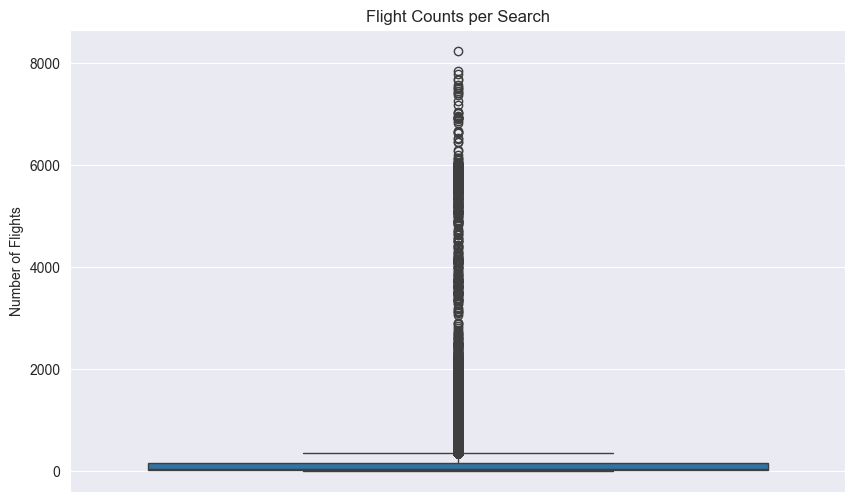

In [14]:
# Plot the distribution of the flight counts per search
plt.figure(figsize=(10, 6))
sns.boxplot(flight_counts['len'])
plt.title('Flight Counts per Search')
plt.ylabel('Number of Flights')
plt.show()

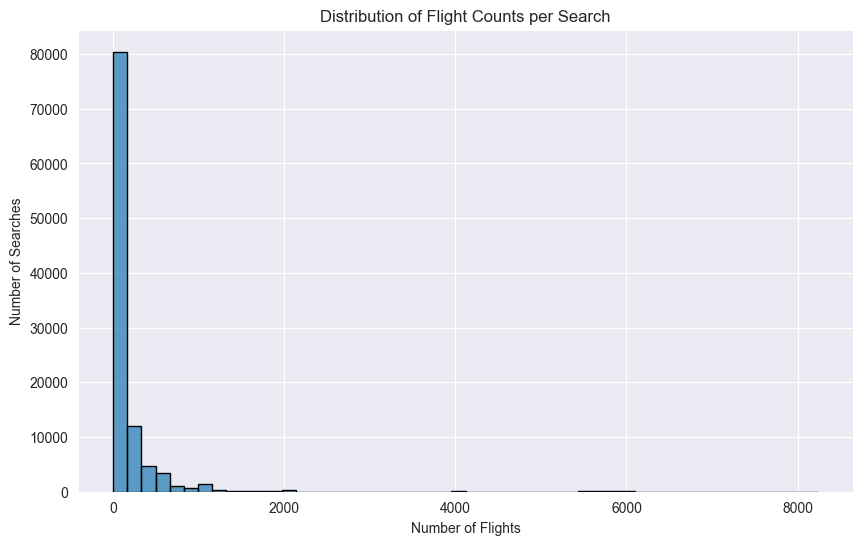

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(flight_counts['len'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Flight Counts per Search')
plt.xlabel('Number of Flights')
plt.ylabel('Number of Searches')
plt.show()

While the number of flight search results per session is generally less than 150 (3rd Quartile), there are significantly large outliers that we will likely need to address.

Let's look at the distribution of the number of flights searched per unique customer

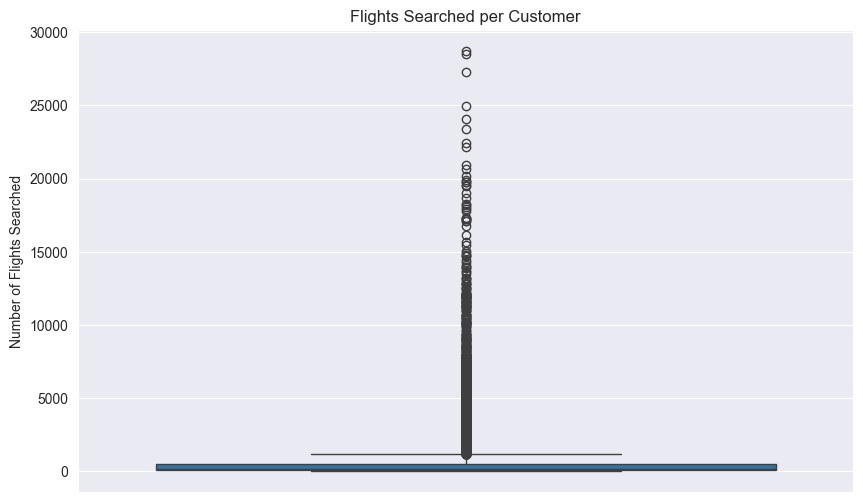

In [4]:
# Plot the distribution of number of flights searched per customer
cust_flights_searched = train_df.lazy().group_by('profileId').len().sort(by='len', descending=True).collect()
plt.figure(figsize=(10, 6))
sns.boxplot(cust_flights_searched['len'])
plt.title('Flights Searched per Customer')
plt.ylabel('Number of Flights Searched')
plt.show()

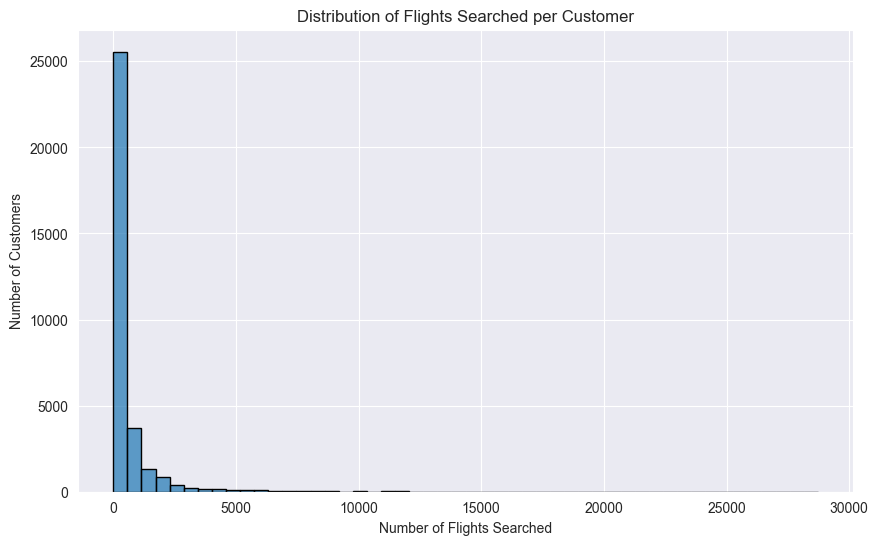

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(cust_flights_searched['len'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Flights Searched per Customer')
plt.xlabel('Number of Flights Searched')
plt.ylabel('Number of Customers')
plt.show()

In [6]:
cust_flights_searched['len'].describe()

statistic,value
str,f64
"""count""",32922.0
"""null_count""",0.0
"""mean""",551.162505
"""std""",1290.835383
"""min""",1.0
"""25%""",53.0
"""50%""",168.0
"""75%""",505.0
"""max""",28718.0


While the majority of customers generally have less than ~500 flight searches (3rd Quartile) there are definitely outliers here.

We'll also look at the number of search sessions per customer

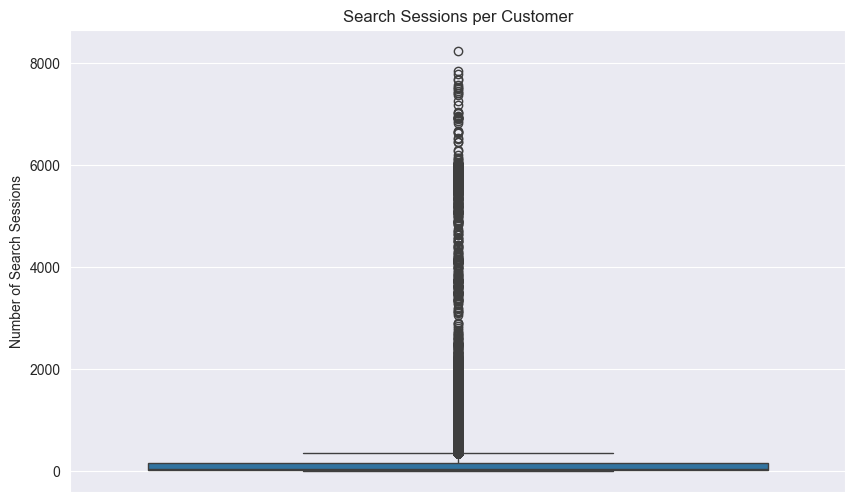

In [7]:
# Plot the distribution of search sessions per customer
cust_searches = train_df.lazy().group_by('profileId', 'ranker_id').len().sort(by='len', descending=True).collect()
plt.figure(figsize=(10, 6))
sns.boxplot(cust_searches['len'])
plt.title('Search Sessions per Customer')
plt.ylabel('Number of Search Sessions')
plt.show()

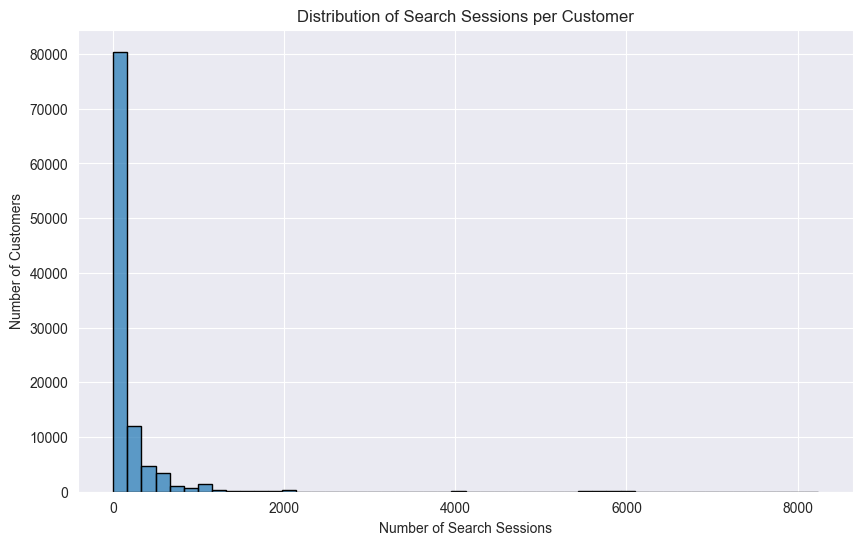

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(cust_searches['len'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Search Sessions per Customer')
plt.xlabel('Number of Search Sessions')
plt.ylabel('Number of Customers')
plt.show()

In [9]:
cust_searches['len'].describe()

statistic,value
str,f64
"""count""",105539.0
"""null_count""",0.0
"""mean""",171.93049
"""std""",445.940118
"""min""",1.0
"""25%""",19.0
"""50%""",50.0
"""75%""",154.0
"""max""",8236.0


The majority of customers have less than ~150 search sessions, with some significant outliers

Now let's check the data types and attributes with NULL/Empty values.

In [13]:
# Check data types
pl.DataFrame({'data_type': [str(dtype) for dtype in train_df.schema.values()]}).group_by('data_type').len().sort('len', descending=True)

data_type,len
str,u32
"""String""",73
"""Float64""",41
"""Int64""",8
"""Boolean""",4
"""Datetime(time_unit='ns', time_…",1


In [14]:
# Determine the number and percentage of NULL/Empty values for each feature
results = []
for col in train_df.columns:
    # Get null count
    null_count = train_df.select(pl.col(col).is_null().sum()).item()
    # Get empty string count
    if train_df.schema[col] == pl.String:
        empty_count = train_df.select((pl.col(col) == "").sum()).item()
        missing_count = train_df.select((pl.col(col).is_null() | (pl.col(col) == "")).sum()).item()
    else:
        empty_count = 0
        missing_count = null_count

    results.append({
        'column': col,
        'data_type': str(train_df.schema[col]),
        'null_count': null_count,
        'empty_count': empty_count,
        'missing_count': missing_count,
        'missing_percentage': round(missing_count / len(train_df) * 100, 2)
    })
null_summary = pl.DataFrame(results)

In [15]:
# features with no NULL/Empty values:
null_summary.filter(pl.col('missing_count') == 0)

column,data_type,null_count,empty_count,missing_count,missing_percentage
str,str,i64,i64,i64,f64
"""Id""","""Int64""",0,0,0,0.0
"""bySelf""","""Boolean""",0,0,0,0.0
"""companyID""","""Int64""",0,0,0,0.0
"""nationality""","""Int64""",0,0,0,0.0
"""isAccess3D""","""Boolean""",0,0,0,0.0
…,…,…,…,…,…
"""sex""","""Boolean""",0,0,0,0.0
"""taxes""","""Float64""",0,0,0,0.0
"""totalPrice""","""Float64""",0,0,0,0.0


In [16]:
# Features with NULL values < 10%
null_summary.filter((pl.col('missing_count') > 0) & (pl.col('missing_percentage') < 10.0)).sort('missing_count')

column,data_type,null_count,empty_count,missing_count,missing_percentage
str,str,i64,i64,i64,f64
"""legs0_segments0_arrivalTo_airp…","""String""",6,2,8,0.0
"""legs0_segments0_aircraft_code""","""String""",14,0,14,0.0
"""legs0_segments0_departureFrom_…","""String""",2,39,41,0.0
"""legs0_segments0_arrivalTo_airp…","""String""",113,1,114,0.0
"""legs0_segments0_baggageAllowan…","""Float64""",1064,0,1064,0.01
…,…,…,…,…,…
"""pricingInfo_isAccessTP""","""Float64""",905045,0,905045,4.99
"""miniRules0_monetaryAmount""","""Float64""",1395743,0,1395743,7.69
"""miniRules1_monetaryAmount""","""Float64""",1395743,0,1395743,7.69


In [17]:
# Features with NULL/Empty values 10% - 50%
null_summary.filter((pl.col('missing_percentage') >= 10.0) & (pl.col('missing_percentage') < 50.0)).sort('missing_count')

column,data_type,null_count,empty_count,missing_count,missing_percentage
str,str,i64,i64,i64,f64
"""legs1_arrivalAt""","""String""",4387201,0,4387201,24.18
"""legs1_departureAt""","""String""",4387201,0,4387201,24.18
"""legs1_duration""","""String""",4387201,0,4387201,24.18
"""legs1_segments0_aircraft_code""","""String""",4387201,0,4387201,24.18
"""legs1_segments0_duration""","""String""",4387201,0,4387201,24.18
…,…,…,…,…,…
"""legs1_segments0_arrivalTo_airp…","""String""",4387237,0,4387237,24.18
"""legs1_segments0_cabinClass""","""Float64""",4525013,0,4525013,24.94
"""legs1_segments0_baggageAllowan…","""Float64""",4527297,0,4527297,24.95


At first glance, I would suspect that the 24% related to missing legs1* features indicate one-way tickets.

In [18]:
# Features with NULL values > 50%
null_summary.filter((pl.col('missing_percentage') >= 50.0)).sort('missing_count')

column,data_type,null_count,empty_count,missing_count,missing_percentage
str,str,i64,i64,i64,f64
"""corporateTariffCode""","""Int64""",9233925,0,9233925,50.89
"""frequentFlyer""","""String""",12012727,0,12012727,66.2
"""legs0_segments1_arrivalTo_airp…","""String""",14311665,0,14311665,78.87
"""legs0_segments1_duration""","""String""",14311665,0,14311665,78.87
"""legs0_segments1_flightNumber""","""String""",14311665,0,14311665,78.87
…,…,…,…,…,…
"""legs1_segments3_duration""","""String""",18145366,0,18145366,100.0
"""legs1_segments3_flightNumber""","""String""",18145366,0,18145366,100.0
"""legs1_segments3_marketingCarri…","""String""",18145366,0,18145366,100.0


Here we see segments3 is 100% empty, meaning none of our flight search results have more than two layovers.

Based on the inspection, some of these features are missing a large percentage of values. Given the description provided for the features, we will do the following:
* corporateTariffCode (Corporate tariff code for businesss travel policies): impute to 0 (zero)
* frequentFlyer (Frequent flyer program status): impute to 'NONE'
* miniRules0_percentage (Percentage penalty for cancellation): impute to 0.0 (zero)
* miniRules1_percentage (Percentage penalty for exchange): impute to 0.0 (zero)
* legs[0,1]_segments[1-3]_* (flight segments): we will remove legs*_segments3_*, since none of the flights have more than two layovers. The remaining NULL values will be imputed to 0 or "", depending on the data type, as these will likely provide behavioral related matching.

Let's look at carrier and frequent flyer codes.

In [19]:
# let's look at carrier codes
unique_carrier_codes = (
    train_df.select(cs.contains("Carrier_code"))
    .unpivot()
    .select("value")
    .filter(pl.col("value").is_not_null())
    .unique().to_series().to_list()
)
print(unique_carrier_codes)

['QS', 'SA', 'V3', '2L', 'PR', 'VZ', '7T', 'KN', 'LH', 'TU', 'AD', 'HU', 'HH', 'AI', 'XC', 'YU', 'CY', 'JI', 'H1', 'UL', 'FB', 'VJ', 'U6', 'R6', 'XY', 'KM', 'ZN', 'AV', 'QR', 'TK', 'IX', 'AH', '8R', 'C3', 'A9', 'PI', 'HZ', 'VN', 'HO', 'SZ', 'N4', 'K6', 'B2', 'FZ', 'LA', 'EH', 'SG', 'G9', 'NH', 'JM', '0V', '8M', 'KB', 'TG', 'T5', '7C', 'AY', 'CX', 'TF', 'LY', 'DP', 'D2', 'JL', 'PK', 'TW', '3F', 'MH', 'TP', 'SN', 'WZ', 'WB', 'ИК', 'MF', 'WK', 'GF', 'YX', '6R', 'A3', 'OO', 'I2', 'OU', 'AT', 'SQ', 'QF', 'PW', 'IO', 'СЛ', 'A5', 'BG', 'LO', 'KA', '3U', 'BR', 'SM', 'GW', 'НИ', 'GA', 'N7', 'VA', 'ДЕ', 'Y7', '4G', 'OS', 'AA', 'BJ', 'KU', 'LV', 'СИ', '5F', '3K', 'FM', 'NX', 'PC', 'WY', '9F', 'A0', 'IZ', 'IQ', '5N', 'OK', 'KL', 'HY', 'AC', 'DY', 'OD', 'BL', 'ME', 'W2', 'BT', 'MQ', 'BA', 'J2', '9B', 'CA', 'KE', 'TC', 'KC', 'SV', 'FV', 'OZ', '7R', '4Y', 'WX', 'JJ', 'NL', 'DV', 'VF', 'AS', 'LX', 'X9', 'JU', 'A4', '5G', '6H', 'T7', 'I8', 'YW', '3L', 'ET', '2P', 'RT', 'TR', 'BI', '7G', 'EI', 'B6', 'F6

In [20]:
carrier_cols = [col for col in train_df.columns if "Carrier_code" in col]
carrier_code_counts = (
    train_df
    .select(pl.concat_list([pl.col(col) for col in carrier_cols]).alias("carrier_codes"))
    .select(pl.col("carrier_codes").explode())
    .filter(pl.col("carrier_codes").is_not_null())
    .select(pl.col("carrier_codes").value_counts())
    .unnest("carrier_codes")
    .sort("count", descending=True)
    .to_pandas()
)

print(carrier_code_counts)

    carrier_codes     count
0              SU  32936951
1              FV  13793095
2              S7   7072584
3              U6   6108252
4              TK   5200093
..            ...       ...
237            PK         1
238            GQ         1
239            XC         1
240            GM         1
241            K6         1

[242 rows x 2 columns]


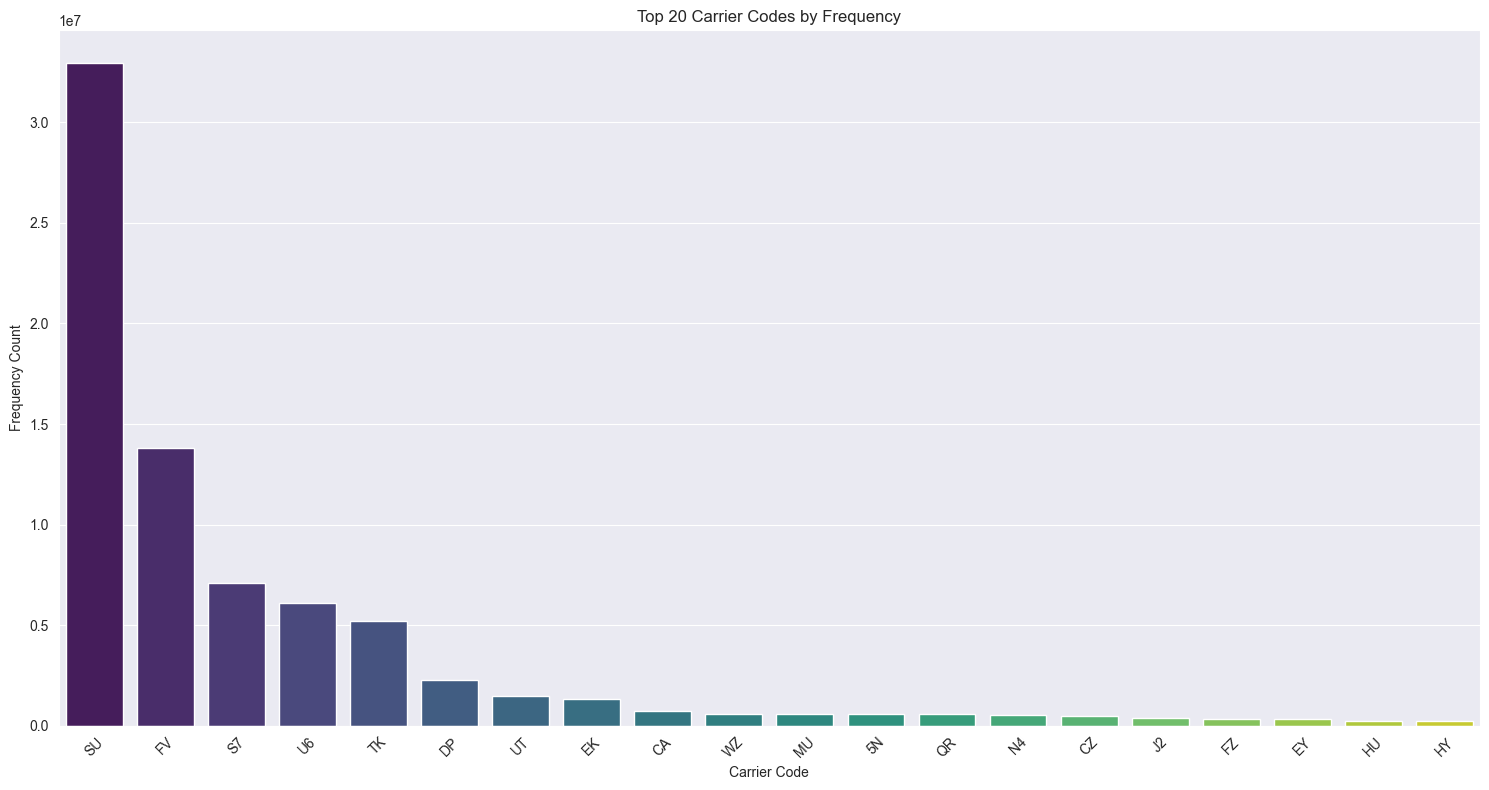

In [21]:
# Show the top 20 carrier codes
plt.figure(figsize=(15, 8))
top_carriers = carrier_code_counts.head(20)
sns.barplot(data=top_carriers, x="carrier_codes", y="count", palette="viridis", hue="carrier_codes")
plt.title("Top 20 Carrier Codes by Frequency")
plt.xlabel("Carrier Code")
plt.ylabel("Frequency Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# Show frequent flyer codes
train_df['frequentFlyer'].unique()

frequentFlyer
str
"""SU/U6/S7/UT"""
"""SU/UT/DP"""
"""SU/SU"""
"""SU/QR"""
"""SU/S7/6R/UT/U6"""
…
"""S7/B2/SU"""
"""S7/DL/SU"""
"""SU/TK/EY/LH"""


In [23]:
# create a list of the unique frequent flyer codes
unique_ff_codes = (
    train_df.select("frequentFlyer")
    .filter(pl.col("frequentFlyer").is_not_null())  # Remove nulls
    .with_columns(
        pl.col("frequentFlyer").str.split("/").alias("ff_codes")  # Split by "/"
    )
    .select("ff_codes")
    .explode("ff_codes")  # Flatten the lists into individual rows
    .unique()  # Get unique codes
    .sort("ff_codes")  # Optional: sort them
    .to_series()
    .to_list()
)
print(unique_ff_codes)

# let's see if any do not have an associated carrier code
ff_not_in_carrier = set(unique_ff_codes) - set(unique_carrier_codes)
print("\nFF codes not in carrier list:", ff_not_in_carrier)


['- ЮТэйр ЗАО', '2G', '5N', '6R', '6W', '9X', 'A3', 'A4', 'AA', 'AB', 'AF', 'AI', 'AM', 'AT', 'AY', 'AZ', 'B2', 'BA', 'BD', 'C7', 'CA', 'CX', 'CZ', 'D2', 'D9', 'DL', 'DP', 'DV', 'EK', 'ET', 'EY', 'FV', 'FZ', 'GF', 'HU', 'HY', 'I8', 'J2', 'JP', 'JU', 'KC', 'KE', 'KL', 'LH', 'LO', 'LX', 'MS', 'MU', 'N4', 'OK', 'OS', 'OZ', 'PY', 'QR', 'R3', 'RT', 'S7', 'SK', 'SN', 'SQ', 'SU', 'SV', 'TK', 'U6', 'UA', 'UN', 'UT', 'VS', 'WY', 'Y7']

FF codes not in carrier list: {'D9', '6W', 'PY', '2G', 'AB', 'C7', 'BD', 'VS', 'JP', '- ЮТэйр ЗАО', '9X', 'UN'}


Frequent Flyer codes to Airlines:
* ЮТэйр ЗАО (translates to 'UTair JSC'):  UTair / UT
* AB: Air Berlin / AB
* D9: Daallo Airlines Somalia / D9
* 2G: Northwest Seaplanes / None
* UN: Transaero Airlines / UN (no longer in service)
* JP: Adria Airways / JP (no longer in service)
* 6W: Unknown
* VS: Virgin Atlantic Airways / VS
* BD: BMI British Midland / BD (integrated into British Airways)
* C7: Cinnamon Air / C7
* PY: Surinam Airways / PY
* 9X: Air Columbia / Unknown

So, translate 'ЮТэйр ЗАО' to UT and we'll keeps the others as they are.

Let's take a look at the airport codes.

In [24]:
iata_cols = [col for col in train_df.columns if "_iata" in col]

unique_iata_codes = (
    train_df
    .select([
        pl.concat_list([pl.col(col) for col in iata_cols])
        .list.explode()
        .drop_nulls()
        .unique()
        .alias('unique_iata_codes')
    ])
    .get_column('unique_iata_codes')
    .to_list()
)

print(f"Found {len(unique_iata_codes)} unique IATA codes")
print(unique_iata_codes)


Found 679 unique IATA codes
['EZV', 'SZX', 'RMO', '', 'YYZ', 'SKX', 'NYM', 'TGO', 'JJN', 'ZDN', 'PNR', 'IRT', 'UUA', 'FEG', 'WVB', 'KCK', 'NNM', 'AEP', 'JXA', 'ZYR', 'TAS', 'ECN', 'BUR', 'TOX', 'BPE', 'XIC', 'RAK', 'PEZ', 'CJB', 'LHR', 'IGU', 'XUZ', 'VCE', 'LOS', 'BDQ', 'LAD', 'AGP', 'ZVJ', 'ASB', 'LKO', 'BJS', 'KBR', 'DUB', 'VCP', 'TRV', 'BZX', 'SAW', 'MLE', 'BCN', 'UUS', 'HYN', 'REN', 'MIA', 'LYA', 'ZUH', 'LYG', 'FCO', 'AMS', 'KZN', 'BRE', 'JED', 'XIL', 'YJV', 'ADA', 'PKC', 'ASF', 'INC', 'HTA', 'LHW', 'VOG', 'GVA', 'IXB', 'OLZ', 'PTY', 'VNS', 'BQS', 'GZT', 'TSR', 'BRI', 'VKO', 'MSP', 'DYG', 'NCU', 'ATH', 'DLM', 'NUE', 'STR', 'VGA', 'BAK', 'YKS', 'YNJ', 'KPW', 'IAD', 'RIO', 'XSP', 'ODO', 'BHX', 'JNZ', 'BXU', 'AAE', 'GOI', 'HEL', 'LLV', 'BUD', 'BHZ', 'GOX', 'DDG', 'ZVR', 'ZIA', 'BLR', 'YBP', 'BTK', 'NGO', 'JGN', 'IJK', 'SZG', 'OSA', 'KQT', 'VVO', 'FUK', 'SVO', 'ARN', 'CGB', 'HLD', 'JGA', 'CTU', 'SEZ', 'DLU', 'EUN', 'SHJ', 'AER', 'HAM', 'SYX', 'XXQ', 'SCW', 'HMA', 'TYD', 'TLV', 'KGF', '

Finally, let's look at the baggage feature

In [34]:
baggage_df = train_df.select(["legs0_segments0_baggageAllowance_weightMeasurementType", "legs0_segments0_baggageAllowance_quantity"])
baggage_df_lazy = baggage_df.lazy()
baggage_df_filtered = baggage_df_lazy.filter(~(pl.col("legs0_segments0_baggageAllowance_weightMeasurementType").is_null()) & ~(pl.col("legs0_segments0_baggageAllowance_quantity").is_null())).collect()

In [27]:
baggage_df_filtered["legs0_segments0_baggageAllowance_weightMeasurementType"].unique()

legs0_segments0_baggageAllowance_weightMeasurementType
f64
0.0
1.0


In [28]:
baggage_df_filtered["legs0_segments0_baggageAllowance_quantity"].unique()

legs0_segments0_baggageAllowance_quantity
f64
0.0
1.0
2.0
3.0
10.0
…
40.0
45.0
46.0


In [29]:
filtered_data = baggage_df_filtered.filter(pl.col("legs0_segments0_baggageAllowance_weightMeasurementType") == 0)
filtered_data["legs0_segments0_baggageAllowance_quantity"].unique()

legs0_segments0_baggageAllowance_quantity
f64
0.0
1.0
2.0
3.0


In [30]:
filtered_data = baggage_df_filtered.filter(pl.col("legs0_segments0_baggageAllowance_weightMeasurementType") == 1)
filtered_data["legs0_segments0_baggageAllowance_quantity"].unique()

legs0_segments0_baggageAllowance_quantity
f64
0.0
10.0
15.0
20.0
23.0
…
40.0
45.0
46.0


Based on this, it looks like a MeasurementType = 0 indicates the Allowance_quantity is the number of bags limit, and when MeasurementType = 1, the Allowance_quanityt is a weight limit.

In [35]:
# Let's clean-up the data objects we generated for the EDA process
del baggage_df
del baggage_df_filtered
del baggage_df_lazy
del carrier_code_counts
del carrier_cols
del cust_searches
del ff_not_in_carrier
del filtered_data
del flight_counts
del iata_cols
del null_summary
del results
del top_carriers
del unique_carrier_codes
del unique_ff_codes
del unique_iata_codes
gc.collect()

21256

### Split Data into Training and Test Data Sets

In [6]:
train_df, test_df = stratified_flight_count_split(train_df)

Search size distribution:
  large: 5,035 searches
  medium: 13,896 searches
  small: 30,360 searches
  very_large: 3,141 searches
  very_small: 53,107 searches

Split results:
Train searches: 84,429
Test searches: 21,110
Train rows: 14,517,539
Test rows: 3,627,833

Train set distribution:
  large: 4,028 searches
  medium: 11,116 searches
  small: 24,288 searches
  very_large: 2,512 searches
  very_small: 42,485 searches

Test set distribution:
  large: 1,007 searches
  medium: 2,780 searches
  small: 6,072 searches
  very_large: 629 searches
  very_small: 10,622 searches


Since the data set is so large, we will need to manage memory throughout the process. To assist with this, I am saving the training and test splits as parquet files that we can reload as needed without having to regenerate new splits.

In [7]:
# Save the train/test splits
train_df.write_parquet('data/train_df.parquet')
test_df.write_parquet('data/test_df.parquet')

# Remove test data from memory
del test_df
gc.collect()

79

### Customer Segmentation

This section will perform the customer segmentation. The goal is to generate the groups of similar customers based on their profile attributes and search history. We will clean the data and engineer additional features to provide insights around flight search and selection behavior.

The process for peforming the customer segmentation is as follows:
1. Feature Engineering
2. Remove outliers
3. Feature encoding
4. Feature scaling
5. Dimensionality reduction
6. Evaluate alternative clustering methods (Gaussian Mixture Model, DBScan, Agglomerative Clustering)
7. Perform hyperparameter optimization
8. Analyze the cluster results
9. Add cluster labels to the customer data set
10. Save customer features


#### Imports for Customer Segmentation

In [18]:
import gc
import joblib
import numpy as np
import polars as pl

# Import libraries and functions needed for Customer Clustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler

# Import project functions
from src.cluster_cust_data import (
    encode_features, remove_outliers, alternative_clustering_methods, gen_optimum_num_clusters, generate_clusters,
    analyze_clusters, predict_cluster_with_centroids
)
from src.cust_feature_eng import extract_customer_features
from src.flt_feature_eng import extract_flight_features, prepare_combined_data
from src.ranking import train_segment_based_ranker
from src.ranking_eval import  test_lgb_ranker, test_segment_based_ranker

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the training data set if not already loaded

In [2]:
# Here we can check if train_df exists and load if we restarted the process at this point.
try:
    train_df.head()
except NameError:
    train_df = pl.read_parquet('data/train_df.parquet')
    print(f'loaded train_df: {train_df.shape}')

train_df.head(100)

loaded train_df: (14517539, 127)


Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,legs0_duration,legs0_segments0_aircraft_code,legs0_segments0_arrivalTo_airport_city_iata,legs0_segments0_arrivalTo_airport_iata,legs0_segments0_baggageAllowance_quantity,legs0_segments0_baggageAllowance_weightMeasurementType,legs0_segments0_cabinClass,legs0_segments0_departureFrom_airport_iata,legs0_segments0_duration,legs0_segments0_flightNumber,legs0_segments0_marketingCarrier_code,legs0_segments0_operatingCarrier_code,legs0_segments0_seatsAvailable,legs0_segments1_aircraft_code,legs0_segments1_arrivalTo_airport_city_iata,legs0_segments1_arrivalTo_airport_iata,legs0_segments1_baggageAllowance_quantity,legs0_segments1_baggageAllowance_weightMeasurementType,legs0_segments1_cabinClass,legs0_segments1_departureFrom_airport_iata,legs0_segments1_duration,legs0_segments1_flightNumber,legs0_segments1_marketingCarrier_code,legs0_segments1_operatingCarrier_code,legs0_segments1_seatsAvailable,legs0_segments2_aircraft_code,legs0_segments2_arrivalTo_airport_city_iata,…,legs1_segments2_baggageAllowance_weightMeasurementType,legs1_segments2_cabinClass,legs1_segments2_departureFrom_airport_iata,legs1_segments2_duration,legs1_segments2_flightNumber,legs1_segments2_marketingCarrier_code,legs1_segments2_operatingCarrier_code,legs1_segments2_seatsAvailable,legs1_segments3_aircraft_code,legs1_segments3_arrivalTo_airport_city_iata,legs1_segments3_arrivalTo_airport_iata,legs1_segments3_baggageAllowance_quantity,legs1_segments3_baggageAllowance_weightMeasurementType,legs1_segments3_cabinClass,legs1_segments3_departureFrom_airport_iata,legs1_segments3_duration,legs1_segments3_flightNumber,legs1_segments3_marketingCarrier_code,legs1_segments3_operatingCarrier_code,legs1_segments3_seatsAvailable,miniRules0_monetaryAmount,miniRules0_percentage,miniRules0_statusInfos,miniRules1_monetaryAmount,miniRules1_percentage,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice,selected,__index_level_0__
i64,bool,i64,i64,str,i64,bool,bool,str,str,str,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,str,…,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,datetime[ns],str,bool,f64,f64,i64,i64
40,true,53407,null,null,36,false,false,"""2024-05-30T18:30:00""","""2024-05-30T16:00:00""","""02:30:00""","""AN4""","""IKT""","""IKT""",20.0,1.0,1.0,"""ODO""","""02:30:00""","""142""","""IO""","""IO""",6.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,1,2447853,"""7ec8ce3fdebd4c9699b03582ebd60d…",2024-05-17 03:10:04,"""ODOIKT""",true,2220.0,16515.0,0,40
41,true,53407,null,null,36,false,false,"""2024-05-30T12:55:00""","""2024-05-30T10:40:00""","""02:15:00""","""AN4""","""IKT""","""IKT""",20.0,1.0,1.0,"""ODO""","""02:15:00""","""898""","""ИК""","""ИК""",9.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,1,2447853,"""7ec8ce3fdebd4c9699b03582ebd60d…",2024-05-17 03:10:04,"""ODOIKT""",true,2485.0,16525.0,1,41
42,true,59096,null,null,36,false,false,"""2024-06-04T15:50:00""","""2024-06-04T11:25:00""","""09:25:00""","""E70""","""OVB""","""OVB""",0.0,0.0,1.0,"""IKT""","""02:30:00""","""5230""","""S7""","""S7""",9.0,"""73H""","""AER""","""AER""",0.0,0.0,1.0,"""OVB""","""05:10:00""","""5105""","""S7""","""S7""",9.0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4000.0,null,1.0,0.0,null,0.0,1.0,1,2384252,"""d2906d4d6a4a4b8ea7406a96080c7a…",2024-05-17 03:31:00,"""IKTAER""",true,1273.0,38793.0,0,42
4

#### Feature Engineering

In the feature engineering step, we will aggregate the training data set by customer to generate customer profile and flight search and selection behavioral features with a goal of generating well defined customer segments for use in the flight ranking process. After evaluating the customer and flight related data, as well as some industry research, the following features will be used or generated:

* Customer profile:
    * company_id, sex, nationality, frequent_flyer, is_vip, by_self (all existing attributes)
    * has_corp_codes, total_flights_searched, total_search_sessions, avg_searches_per_session, unique_routes_searched
* Booking Lead Time:
    * min_booking_lead_days, max_booking_lead_days, avg_booking_lead_days, median_booking_lead_days
* Travel Preferences:
    * most_common_departure_airport, unique_departure_airports, most_common_carrier, unique_carriers_used, round_trip_preference
* Cabin Class Preferences:
    * min_cabin_class, max_cabin_class, avg_cabin_class
* Temporal Preferences:
    * weekday_preference, return_weekday_preference, weekend_travel_rate, return_weekend_travel_rate, time_of_day_variance, night_flight_preference, redeye_flight_preference
* Route Specific Preferences:
    * route_loyalty, hub_preference, short_haul_preference, connection_tolerance, preferred_duration_quartile
* Price Sensitivity:
    * price_to_duration_sensitivity, avg_price_per_minute, price_per_minute_variance, price_position_preference, premium_economy_preference, consistent_price_tier (quartile), preferred_price_tier (quartile)
* Service Preference:
    * baggage_qty_preference, baggage_weight_preference,
    * loyalty_program_utilization
* Derived Metrics:
    * convenience_priority_score, loyalty_vs_price_index, planning_consistency_score, luxury_index, search_intensity_per_route, lead_time_variance, lead_time_skew, carrier_diversity, airport_diversity, cabin_class_range, customer_tier
* Interaction Features (to distiguish vip and corporate customers):
    * vip_search_intensity, vip_carrier_diversity, vip_cabin_preference
    * corp_search_volume, corp_roundtrip_preference, corp_planning_variance

In [3]:
# 1. Feature Engineering
cust_data = extract_customer_features(train_df)
print(f'Generated {len(cust_data.columns)} customer features for {len(cust_data)} customers')
cust_data.head()

Generated 63 customer features for 29991 customers


profileId,company_id,sex,nationality,frequent_flyer,is_vip,by_self,has_corp_codes,total_flights_searched,total_search_sessions,avg_searches_per_session,unique_routes_searched,min_booking_lead_days,max_booking_lead_days,avg_booking_lead_days,median_booking_lead_days,most_common_departure_airport,unique_departure_airports,most_common_carrier,unique_carriers_used,roundtrip_preference,min_cabin_class,max_cabin_class,avg_cabin_class,weekday_preference,return_weekday_preference,weekend_travel_rate,return_weekend_travel_rate,time_of_day_variance,night_flight_preference,redeye_flight_preference,route_loyalty,hub_preference,short_haul_preference,connection_tolerance,preferred_duration_quartile,price_to_duration_sensitivity,avg_price_per_minute,price_per_minute_variance,price_position_preference,premium_economy_preference,consistent_price_tier,preferred_price_tier,baggage_qty_preference,baggage_weight_preference,loyalty_program_utilization,convenience_priority_score,loyalty_vs_price_index,planning_consistency_score,luxury_index,search_intensity_per_route,lead_time_variance,lead_time_skew,carrier_diversity,airport_diversity,cabin_class_range,customer_tier,vip_search_intensity,vip_carrier_diversity,vip_cabin_preference,corp_search_volume,corp_roundtrip_pref,corp_planning_variance
i64,i64,i8,i64,str,i8,i8,i8,u32,u32,f64,u32,i32,i32,f64,f64,str,u32,str,u32,f64,f64,f64,f64,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64,i8,f64,f64,f64,i64,f64,i32
3275557,63398,1,36,"""""",0,1,1,2,1,2.0,1,5,5,5.0,5.0,"""PEZ""",1,"""S7""",1,0.0,1.0,1.0,1.0,3,-1,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.688889,1.0,1,0.0,87.4375,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0,0.0,1.0,20.0,2.0,0,1.0,0.5,0.5,0.0,1,0.0,0.0,0.0,2,0.0,0
2709554,16636,0,36,"""SU""",0,1,0,36,1,36.0,1,16,16,16.0,16.0,"""SVO""",1,"""SU""",1,1.0,1.0,1.0,1.0,1,7,0.0,1.0,0.0,0.0,0.0,0.972222,0.0,0.0,1.0,1,0.0,83.502222,0.0,54.285714,0.0,1.0,3,0.0,0.0,1.0,0.0,4.571429,1.0,47.142857,36.0,0,1.0,0.027778,0.027778,0.0,1,0.0,0.0,0.0,0,0.0,0
2897662,61295,0,36,"""""",0,1,1,32,1,32.0,1,5,5,5.0,5.0,"""IJK""",1,"""SU""",1,1.0,1.0,1.0,1.0,2,5,0.0,1.0,0.0,0.0,0.0,0.96875,0.0,0.552778,1.0,1,0.0,63.017391,0.0,3.225806,0.0,1.0,1,1.0,0.0,0.0,0.0,-0.322581,1.0,21.612903,32.0,0,1.0,0.03125,0.03125,0.0,1,0.0,0.0,0.0,32,1.0,0
1642450,52573,1,36,"""""",0,1,1,1179,10,117.9,2,3,8,4.5,4.0,"""KUF""",1,"""SU""",4,0.8,1.0,1.0,1.0,7,5,0.6,0.5,6.703233,0.0,0.0,0.998304,0.0,0.578056,1.0,1,0.528196,81.346213,36.056411,16.110642,0.0,0.718909,1,0.2,0.0,0.0,-54.391349,-1.611064,0.166667,28.055321,589.5,5,1.125,0.003393,0.000848,0.0,1,0.0,0.0,0.0,1179,0.8,5
2996106,42620,1,36,"""""",0,1,1,220,3,73.333333,3,2,7,4.333333,4.0,"""TJM""",3,"""S7""",2,0.333333,1.0,1.0,1.0,1,2,0.0,0.0,9.643651,0.333333,0.333333,0.986364,0.0,0.552778,1.0,2,0.217082,96.315,39.770865,11.583333,0.0,0.80755,1,0.333333,0.0,0.0,-85.3511,-1.158333,0.166667,25.791667,73.333333,5,1.083333,0.009091,0.013636,0.0,1,0.0,0.0,0.0,220,0.333333,5


Prepare features for training the unsupervised models

In [4]:
# 2. Remove outliers
cust_data_cleaned, outlier_indices = remove_outliers(cust_data, contamination=0.05)

Removed 1,500 outliers (5.0%)


In [5]:
# 3. Feature encoding
cust_data_encoded, encoders = encode_features(cust_data_cleaned)

In [6]:
# 4. Feature scaling
scaler = RobustScaler()
scaled_features = scaler.fit_transform(cust_data_encoded.to_pandas())

In [7]:
# 5. Dimensionality reduction
n_components = 0.95  # retain components that explain 95% of variance
# n_components = 15    # retain 30 components

reducer = PCA(n_components=n_components, random_state=42)
reduced_features = reducer.fit_transform(scaled_features)

if hasattr(reducer, 'explained_variance_ratio_'):
    total_variance = reducer.explained_variance_ratio_.sum()
    print(f"PCA retained {total_variance:.3f} of total variance with {reduced_features.shape[1]} components")

PCA retained 0.950 of total variance with 9 components


Now we will evaluate the Gaussian Mixture Model, DBScan, and Agglomerative Clustering methods on the Customer Features data

In [8]:
# 6. Try alternative clustering methods
clustering_results = alternative_clustering_methods(reduced_features)

# ... and show each method's best results
for method, results in clustering_results.items():
    print(f"{method.upper():15s} | Silhouette: {results['silhouette']:.4f} | Clusters: {results['n_clusters']:2d}")

Testing Gaussian Mixture Models...
Testing DBSCAN...
eps: 0.50 | Clusters: 7 | Noise: 71.63% | Silhouette: 0.3412
eps: 0.70 | Clusters: 8 | Noise: 55.23% | Silhouette: 0.5195
eps: 1.00 | Clusters: 6 | Noise: 37.47% | Silhouette: 0.5708
eps: 1.50 | Clusters: 9 | Noise: 22.58% | Silhouette: 0.5540
Testing Agglomerative Clustering...
GMM             | Silhouette: 0.0749 | Clusters: 15
DBSCAN          | Silhouette: 0.5708 | Clusters:  6
AGGLOMERATIVE   | Silhouette: 0.4583 | Clusters: 15


GMM performed poorly on this data set. DBSCAN fared pretty well and generated a reasonable set of clusters, but the noise ratio is higher than preferred. Out of the three methods, Agglomerative Clustering performed the best.

As such, we will optimize the hyperparameter configuration and return the best model and results for our unsupervised learning method.

In [9]:
# 7. Perform hyperparameter optimization
clustering_results = gen_optimum_num_clusters(reduced_features, min_clusters=4, max_clusters=16, step=1)

# 7. Clustering results
print("\n🏆 CLUSTERING RESULTS:")
print(f"  Clusters: {clustering_results['n_clusters']:2d}| Silhouette: {clustering_results['silhouette']:.4f} | ")

n_clusters=4, linkage=ward, metric=euclidean: 0.6026
n_clusters=5, linkage=ward, metric=euclidean: 0.6359
n_clusters=6, linkage=ward, metric=euclidean: 0.6360
n_clusters=7, linkage=ward, metric=euclidean: 0.6445
n_clusters=8, linkage=ward, metric=euclidean: 0.6005
n_clusters=9, linkage=ward, metric=euclidean: 0.4381
n_clusters=10, linkage=ward, metric=euclidean: 0.4511
n_clusters=11, linkage=ward, metric=euclidean: 0.4510
n_clusters=12, linkage=ward, metric=euclidean: 0.4532
n_clusters=13, linkage=ward, metric=euclidean: 0.4582
n_clusters=14, linkage=ward, metric=euclidean: 0.4583
n_clusters=15, linkage=ward, metric=euclidean: 0.4583
n_clusters=16, linkage=ward, metric=euclidean: 0.3070
n_clusters=4, linkage=complete, metric=euclidean: 0.9681
n_clusters=5, linkage=complete, metric=euclidean: 0.9349
n_clusters=6, linkage=complete, metric=euclidean: 0.9349
n_clusters=7, linkage=complete, metric=euclidean: 0.9111
n_clusters=8, linkage=complete, metric=euclidean: 0.8446
n_clusters=9, linka

In [10]:
clustering_results

{'labels': array([0, 0, 0, ..., 0, 0, 0], shape=(28491,)),
 'centroids': array([[-4.09819263e-01, -1.01283646e-03, -5.33896081e-04,
         -8.38510502e-04, -2.12780057e-04, -5.89040848e-05,
         -4.58161729e-05, -1.07372048e-04,  4.63044338e-05],
        [ 6.66598484e+02,  2.69961934e+00,  5.32647089e-01,
          1.60386127e+00,  2.11216086e+00, -9.26145150e-02,
          8.20346135e-01, -2.00479744e-01,  2.16706027e-01],
        [ 3.94929856e+02,  7.12692247e-01,  5.76055771e-01,
          7.06690484e-01, -4.09120107e-02,  9.70978048e-02,
         -8.25723020e-02,  1.44205985e-01, -4.98863777e-02],
        [ 9.77253018e+02,  5.05230223e+00,  9.26183723e-01,
          3.50942697e+00,  6.20365971e-01, -1.81603388e-01,
          6.59709599e-01,  4.85252908e-01, -8.70673479e-01]]),
 'model': AgglomerativeClustering(linkage='complete', n_clusters=4),
 'silhouette': 0.9681101342773389,
 'n_clusters': 4}

In [11]:
# Analyze the cluster results
analyze_clusters(cust_data_cleaned, clustering_results['labels'])


CLUSTER PROFILES:


,cluster,avg_flights_searched,vip_rate,roundtrip_rate,avg_lead_days,avg_carriers,avg_cabin_class,avg_loyalty_utilization,avg_price_position_preference,avg_preferred_price_tier,avg_connection_tolerance,avg_weekend_travel_rate,avg_night_flight_preference,size
0,0,432.597400,0.003373,0.531282,15.013311,1.412577,1.018713,0.138753,21.507410,1.491973,1.147152,0.304719,0.120502,28465
1,1,667.333333,1.000000,1.000000,12.250000,1.333333,1.000000,0.083333,26.390886,1.666667,1.083333,0.083333,0.000000,3
2,2,610.954545,1.000000,0.831818,10.617424,1.181818,1.000000,0.363636,27.918917,1.636364,1.000000,0.213636,0.000000,22
3,3,978.000000,1.000000,1.000000,14.000000,1.000000,1.000000,0.000000,31.064318,2.000000,1.000000,0.000000,0.000000,1


While using linkage = 'complete' and metric = 'euclidean' (default) had the best silhoutte score with 4 clusters, the linkage = 'average' and metric = 'euclidean' performed more consistently across the range of clusters. My primary concern with the 4 clusters shown above, is that most customers are grouped in a single cluster with the other 3 clusters being very small. This leads me to believe that we might be overfitting the data and may also need to revisit the feature engineering and feature selection process.

To evaluate the clustering in more detail, we will select some combinations of the metrics from the tuning and see how they perform on the test data set.

In [20]:
# Save the current cleaned data and reduced feature set for easier re-use
np.save('data/reduced_features.npy', reduced_features)
cust_data_cleaned.write_parquet('data/cust_data_cleaned.parquet')

In [26]:
# Let's generate and test several variations of the Agglomerative Cluster model
agg1 = generate_clusters(reduced_features, n_clusters=6, linkage='average', metric='euclidean')
agg2 = generate_clusters(reduced_features, n_clusters=10, linkage='average', metric='euclidean')
agg3 = generate_clusters(reduced_features, n_clusters=7, linkage='complete', metric='euclidean')
agg4 = generate_clusters(reduced_features, n_clusters=7, linkage='ward', metric='euclidean')

In [27]:
# get test data set and prepare it for clustering
test_df = pl.read_parquet('data/test_df.parquet')
# Feature engineering
test_data = extract_customer_features(test_df)
# Encode customer features
test_data_encoded, _ = encode_features(test_data, encoders)
# Scale customer features
test_data_scaled = scaler.transform(test_data_encoded.to_pandas())
# Dimensionality reduction
test_data_reduced = reducer.transform(test_data_scaled)

In [28]:
# Let's test the models on the test data set
from sklearn.metrics import silhouette_score

agg1_pred, _ = predict_cluster_with_centroids(test_data_reduced, agg1['centroids'])
agg1_silhoutte = silhouette_score(test_data_reduced, agg1_pred)
print(f'model 1 silhoutte score: {agg1_silhoutte:.4f}')

agg2_pred, _ = predict_cluster_with_centroids(test_data_reduced, agg2['centroids'])
agg2_silhoutte = silhouette_score(test_data_reduced, agg2_pred)
print(f'model 2 silhoutte score: {agg2_silhoutte:.4f}')

agg3_pred, _ = predict_cluster_with_centroids(test_data_reduced, agg3['centroids'])
agg3_silhoutte = silhouette_score(test_data_reduced, agg3_pred)
print(f'model 3 silhoutte score: {agg3_silhoutte:.4f}')

agg4_pred, _ = predict_cluster_with_centroids(test_data_reduced, agg4['centroids'])
agg4_silhoutte = silhouette_score(test_data_reduced, agg4_pred)
print(f'model 4 silhoutte score: {agg4_silhoutte:.4f}')

# run test data against the best model
best_model_pred, _ = predict_cluster_with_centroids(test_data_reduced, clustering_results['centroids'])
best_model_silhoutte = silhouette_score(test_data_reduced, best_model_pred)
print(f'best model silhoutte score: {best_model_silhoutte:.4f}')

model 1 silhoutte score: 0.8406
model 2 silhoutte score: 0.8422
model 3 silhoutte score: 0.8388
model 4 silhoutte score: 0.6867
best model silhoutte score: 0.9518


In [30]:
# Let's compare the clustering distribution results
print(f'agg1 clusters:\n{np.asarray(np.unique(agg1_pred, return_counts=True)).T}')
print(f'agg2 clusters:\n{np.asarray(np.unique(agg2_pred, return_counts=True)).T}')
print(f'agg3 clusters:\n{np.asarray(np.unique(agg3_pred, return_counts=True)).T}')
print(f'agg4 clusters:\n{np.asarray(np.unique(agg4_pred, return_counts=True)).T}')
print(f'best model clusters:\n{np.asarray(np.unique(best_model_pred, return_counts=True)).T}')

agg1 clusters:
[[    0    61]
 [    1   135]
 [    2     3]
 [    3    20]
 [    4    16]
 [    5 13562]]
agg2 clusters:
[[    0     3]
 [    1   128]
 [    2 13531]
 [    3    42]
 [    4    13]
 [    5     3]
 [    6    37]
 [    7    20]
 [    8    16]
 [    9     4]]
agg3 clusters:
[[    0 13585]
 [    1   109]
 [    2    26]
 [    3    20]
 [    4     9]
 [    5    45]
 [    6     3]]
agg4 clusters:
[[    0   743]
 [    1 11921]
 [    2   195]
 [    3    71]
 [    4   702]
 [    5    29]
 [    6   136]]
best model clusters:
[[    0 13671]
 [    1    16]
 [    2    90]
 [    3    20]]


In general, most customers reside in one large cluster. Model 4 showed the highest distribution, but has the lowest silhoutte score when evaluating the clustering.

Based on the evaluation results, let's stick with the "best" 4-cluster model and move to the next steps.

In [31]:
# Add cluster labels to the customer data set
cust_data_cleaned = cust_data_cleaned.with_columns(pl.Series('customer_segment', clustering_results['labels']))

In [34]:
# Save customer features
cust_data_cleaned.write_parquet('data/train_customer_features.parquet')

In [35]:
# Save the best Agglomerative model
joblib.dump(clustering_results, 'data/agglomerative_model.joblib')

# Save the data encoders/scaler/reducer
joblib.dump({
    'encoders': encoders,
    'scaler': scaler,
    'reducer': reducer
}, 'data/data_encoders_scaler_reducer.joblib')

['data/data_encoders_scaler_reducer.joblib']

In [36]:
# Remove unneeded objects to free memory
del GaussianMixture
del PCA
del clustering_results
del cust_data
del cust_data_cleaned
del cust_data_encoded
del encoders
del outlier_indices
del reduced_features
del reducer
del results
del scaled_features
del scaler
gc.collect()

839

In [37]:
# Remove the multiple testing objects too...
del agg1
del agg1_pred
del agg1_silhoutte
del agg2
del agg2_pred
del agg2_silhoutte
del agg3
del agg3_pred
del agg3_silhoutte
del agg4
del agg4_pred
del agg4_silhoutte
del best_model_pred
del best_model_silhoutte
del test_df
del test_data
del test_data_encoded
del test_data_reduced
del test_data_scaled
gc.collect()

0

### Flight Ranking

This section will perform the flight search results ranking. The goal is to predict the top 3 flights that meet the customer's selection behavior, based on the customer segmentation, flight features, and interactive features between the customer profile and flight data.

The process will begin by cleaning the data and engineering additional features to provide insights around flight attributes. Customer features will be added to the updated flight feature set and interactive features will be generated to provide additional selection insight. Once all feature engineering is completed, the LightGBM model will be trained for ranking the ranking all flights within thier respective search session. A separate model will be trained for each customer segment, as well as a model trained on the entire data set. From this, we are looking to determine if the clustering of customers enhances the predictivec capabilites of the model, or if the combined data set with all customer features is better at identifying the differences.

The process for peforming the ranking is as follows:
1. Feature Engineering of flight features
2. Prepare Training Data
    * combine Customer features with Flight features
    * generate interactive Customer/Flight features
    * generate groups to support efficient training of LightGBM model for such a large data set
        * grouping ensures that search sessions are not split across different groups for ranking.
3. Train LightGBM model for ranking
    * train a model for each customer segment
    * train a model for the entire data set
4. Evaluate the models on the Test Data
5. Analyze the results


#### Feature Engineering

In the feature engineering step, we will generate additional features to generalize some features of the search session, such as is_roundtrip, as well as features that can assist in determining flight selection behaviors, such as is_weekend and carrier/frequent_flyer match. After evaluating the customer and flight related data, as well as some industry research, the following features will be used or generated:

* Basic flight features
    * is_access3D, is_roundtrip, route_origin, origin_is_major_hub, destination_is_major_hub
* Flight segment features
    * leg0_num_segments, leg1_num_segments, total_segments, leg0_flight_time_min, leg1_flight_time_min
* Time related features
    * booking_lead_days, leg0_duration_minutes (including layovers), leg1_duration_minutes (including layovers),
    * trip_duration_minutes (including layovers),
    * leg0_departure_hour, leg0_departure_weekday, leg0_arrival_hour, leg0_arrival_weekday,
    * leg1_departure_hour, leg1_departure_weekday, leg1_arrival_hour, leg1_arrival_weekday,
* Flight service features
    * has_cancellation_fee, has_exchange_fee, max_cabin_class, baggage_allowance_qty, baggage_allowance_weight,
    * avg_cabin_class, min_seats_available, total_seats_available
* Carrier features
    * unique_carriers, primary_carrier, marketing_carrier, aircraft_diversity, primary_aircraft
* Derived flight features (based on other engineered features)
    * is_daytime, is_weekend, is_redeye, has_connections
* Windows based features (based on search session)
    * price_percentile, price_rank_pct, price_ratio_to_min, route_popularity, route_popularity_log


In [35]:
# Load training data if not already loaded
try:
    train_df.head()
except NameError:
    train_df = pl.read_parquet('data/train_df.parquet')

In [36]:
train_df = extract_flight_features(train_df)

In [37]:
train_df.head(100)

Id,corporateTariffCode,miniRules0_monetaryAmount,miniRules0_percentage,miniRules0_statusInfos,miniRules1_monetaryAmount,miniRules1_percentage,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,selected,price_percentile,price_rank_pct,price_ratio_to_min,route_popularity,route_popularity_log,is_access3D,is_roundtrip,route_origin,origin_is_major_hub,destination_is_major_hub,includes_major_hub,leg0_num_segments,leg1_num_segments,total_segments,leg0_flight_time_min,leg1_flight_time_min,booking_lead_days,leg0_duration_minutes,leg1_duration_minutes,trip_duration_minutes,leg0_departure_hour,leg0_departure_weekday,leg0_arrival_hour,leg0_arrival_weekday,leg1_departure_hour,leg1_arrival_hour,leg1_departure_weekday,leg1_arrival_weekday,has_cancellation_fee,has_exchange_fee,max_cabin_class,avg_cabin_class,min_seats_available,total_seats_available,baggage_allowance_quantity,baggage_allowance_weight,unique_carriers,primary_carrier,marketing_carrier,has_mkt_ff,has_op_ff,aircraft_diversity,primary_aircraft,is_daytime,is_weekend,is_redeye,has_connections
i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,i64,f64,f64,f64,u32,f64,i32,i8,str,i32,i32,i32,u32,u32,u32,i32,i32,i32,i32,i32,i32,i8,i8,i8,i8,i8,i8,i8,i8,i32,i32,f64,f64,f64,f64,f64,f64,u32,str,str,i32,i32,u32,str,i8,i8,i8,i8
0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",1,0.0,0.04,1.0,25,3.258097,0,1,"""TLK""",0,0,0,1,1,2,160,155,29,160,155,315,15,6,16,6,9,14,2,2,0,0,1.0,1.0,9.0,18.0,1.0,0.0,1,"""KV""","""KV""",0,0,1,"""YK2""",1,1,0,1
1,123,2300.0,0.0,1.0,3500.0,0.0,1.0,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",0,4.166667,0.08,3.028015,25,3.258097,1,1,"""TLK""",0,0,0,2,2,4,250,245,29,445,505,950,9,6,14,6,22,8,2,3,1,1,1.0,1.0,4.0,26.0,1.0,0.0,1,"""S7""","""S7""",1,1,1,"""E70""",1,1,0,1
2,0,2300.0,0.0,1.0,3500.0,0.0,1.0,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",0,29.166667,0.32,3.18023,25,3.258097,0,1,"""TLK""",0,0,0,2,2,4,250,245,29,445,505,950,9,6,14,6,22,8,2,3,1,1,1.0,1.0,4.0,26.0,1.0,0.0,1,"""S7""","""S7""",1,1,1,"""E70""",1,1,0,1
3,123,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",0,54.166667,0.56,4.849562,25,3.258097,1,1,"""TLK""",0,0,0,2,2,4,250,245,29,445,505,950,9,6,14,6,22,8,2,3,0,0,1.0,1.0,4.0,26.0,1.0,0.0,1,"""S7""","""S7""",1,1,1,"""E70""",1,1,0,1
4,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",0,79.166667,0.8,5.097726,25,3.258097,0,1,"""TLK""",0,0,0,2,2,4,250,245,29,445,505,950,9,6,14,6,22,8,2,3,0,0,1.0,1.0,4.0,26.0,1.0,0.0,1,"""S7""","""S7""",1,1,1,"""E70""",1,1,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
159,0,4000.0,0.0,1.0,0.0,0.0,0.0,1.0,1,2503394,"""e109b50aca4a43908dd146c55733e3…",0,46.875,0.484848,4.570697,6663,8.804475,0,0,"""KJA""",0,0,0,2,0,2,225,0,6,395,0,395,19,4,3,5,0,0,0,0,1,0,1.0,1.0,9.0,18.0,0.0,0.0,1,"""S7""","""S7""",0,0,1,"""E70""",1,0,1,1
160,131,2300.0,0.0,1.0,3500.0,0.0,1.0,1.0,1,2503394,"""e109b50aca4a43908dd146c55733e3…",0,56.25,0.575758,5.286202,6663,8.804475,1,0,"""KJA""",0,0,0,2,0,2,225,0,6,395,0,395,19,4,3,5,0,0,0,0,1,1,1.0,1.0,9.0,18.0,1.0,0.0,1,"""S7""","""S7""",0,0,1,"""E70""",1,0,1,1
161,0,2300.0,0.0,1.0,3500.0,0.0,1.0,1.0,1,2503394,"""e109b50aca4a43908dd146c55733e3…",0,65.625,0.666667,5.606259,6663,8.804475,0,0,"""KJA""",0,0,0,2,0,2,225,0,6,395,0,395,19,4,3,5,0,0,0,0,1,1,1.0,1.0,9.0,18.0,1.0,0.0,1,"""S7""","""S7""",0,0,1,"""E70""",1,0,1,1


In [38]:
# Save flight features for train data so that we can reuse it in iterative steps without having to regenerate the features.
train_df.write_parquet('data/train_flight_features.parquet')

In [10]:
# Load training data with flight features if not loaded (supports iterative runs through the process steps)
try:
    train_df['is_roundtrip'][0]
except NameError:
    train_df = pl.read_parquet('data/train_flight_features.parquet')
    print(f'loaded flight features from parquet file: {train_df.shape}')
except pl.exceptions.ColumnNotFoundError:
    # we have a train_df, but it does not have the engineered flight features
    train_df = pl.read_parquet('data/train_flight_features.parquet')
    print(f'incorrect train_df dataframe, loaded flight features from parquet file: {train_df.shape}')

#### Prepare Training Data

In this section we will:
* Combine Customer features with Flight features
* Generate interactive Customer/Flight features
* Generate groups to support efficient training of LightGBM model for such a large data set
    * grouping ensures that search sessions are not split across different groups for ranking.

The additional interactive Customer/Flight features that will be generated are:
* daytime_alignment, weekend_alignment, departure_weekday_match, return_departure_weekday_match, redeye_alignment,
* price_preference_match, carrier_loyalty_match, carrier_ff_match

In [11]:
# Prepare training data by combining customer features with flight features
train_df = prepare_combined_data(train_df, pl.scan_parquet('data/train_customer_features.parquet'))  # loading cust_features lazy

In [13]:
print(f'shape of train_df: {train_df.shape}')
train_df.head(100)

shape of train_df: (12474873, 130)


Id,corporateTariffCode,miniRules0_monetaryAmount,miniRules0_percentage,miniRules0_statusInfos,miniRules1_monetaryAmount,miniRules1_percentage,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,ranker_id,selected,price_percentile,price_rank_pct,price_ratio_to_min,route_popularity,route_popularity_log,is_access3D,is_roundtrip,route_origin,origin_is_major_hub,destination_is_major_hub,includes_major_hub,leg0_num_segments,leg1_num_segments,total_segments,leg0_flight_time_min,leg1_flight_time_min,booking_lead_days,leg0_duration_minutes,leg1_duration_minutes,trip_duration_minutes,leg0_departure_hour,leg0_departure_weekday,leg0_arrival_hour,leg0_arrival_weekday,leg1_departure_hour,…,preferred_duration_quartile,price_to_duration_sensitivity,avg_price_per_minute,price_per_minute_variance,price_position_preference,premium_economy_preference,consistent_price_tier,preferred_price_tier,baggage_qty_preference,baggage_weight_preference,loyalty_program_utilization,convenience_priority_score,loyalty_vs_price_index,planning_consistency_score,luxury_index,search_intensity_per_route,lead_time_variance,lead_time_skew,carrier_diversity,airport_diversity,cabin_class_range,customer_tier,vip_search_intensity,vip_carrier_diversity,vip_cabin_preference,corp_search_volume,corp_roundtrip_pref,corp_planning_variance,customer_segment,daytime_alignment,weekend_alignment,departure_weekday_match,return_departure_weekday_match,redeye_alignment,price_preference_match,carrier_loyalty_match,carrier_ff_match
i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,f64,f64,f64,u32,f64,i32,i8,str,i32,i32,i32,u32,u32,u32,i32,i32,i32,i32,i32,i32,i8,i8,i8,i8,i8,…,i32,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64,i8,f64,f64,f64,i64,f64,i32,i64,f64,f64,i8,i8,f64,f64,i8,i8
0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,"""98ce0dabf6964640b63079fbafd42c…",1,0.0,0.04,1.0,25,3.258097,0,1,"""TLK""",0,0,0,1,1,2,160,155,29,160,155,315,15,6,16,6,9,…,1,0.868215,58.347192,14.217692,3.921569,0.0,1.0,1,0.75,0.0,0.5,-34.903214,4.607843,0.055556,21.960784,23.5,17,1.054054,0.042553,0.031915,0.0,1,0.0,0.0,0.0,94,0.25,17,0,1.0,0.5,0,1,0.0,0.156863,0,0
1,123,2300.0,0.0,1.0,3500.0,0.0,1.0,1.0,1,"""98ce0dabf6964640b63079fbafd42c…",0,4.166667,0.08,3.028015,25,3.258097,1,1,"""TLK""",0,0,0,2,2,4,250,245,29,445,505,950,9,6,14,6,22,…,1,0.868215,58.347192,14.217692,3.921569,0.0,1.0,1,0.75,0.0,0.5,-34.903214,4.607843,0.055556,21.960784,23.5,17,1.054054,0.042553,0.031915,0.0,1,0.0,0.0,0.0,94,0.25,17,0,1.0,0.5,0,1,0.0,0.313725,0,1
2,0,2300.0,0.0,1.0,3500.0,0.0,1.0,1.0,1,"""98ce0dabf6964640b63079fbafd42c…",0,29.166667,0.32,3.18023,25,3.258097,0,1,"""TLK""",0,0,0,2,2,4,250,245,29,445,505,950,9,6,14,6,22,…,1,0.868215,58.347192,14.217692,3.921569,0.0,1.0,1,0.75,0.0,0.5,-34.903214,4.607843,0.055556,21.960784,23.5,17,1.054054,0.042553,0.031915,0.0,1,0.0,0.0,0.0,94,0.25,17,0,1.0,0.5,0,1,0.0,1.254902,0,1
3,123,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1,"""98ce0dabf6964640b63079fbafd42c…",0,54.166667,0.56,4.849562,25,3.258097,1,1,"""TLK""",0,0,0,2,2,4,250,245,29,445,505,950,9,6,14,6,22,…,1,0.868215,58.347192,14.217692,3.921569,0.0,1.0,1,0.75,0.0,0.5,-34.903214,4.607843,0.055556,21.960784,23.5,17,1.054054,0.042553,0.031915,0.0,1,0.0,0.0,0.0,94,0.25,17,0,1.0,0.5,0,1,0.0,2.196078,0,1
4,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1,"""98ce0dabf6964640b63079fbafd42c…",0,79.166667,0.8,5.097726,25,3.258097,0,1,"""TLK""",0,0,0,2,2,4,250,245,29,445,505,950,9,6,14,6,22,…,1,0.868215,58.347192,14.217692,3.921569,0.0,1.0,1,0.75,0.0,0.5,-34.903214,4.607843,0.055556,21.960784,23.5,17,1.054054,0.042553,0.031915,0.0,1,0.0,0.0,0.0,94,0.25,17,0,1.0,0.5,0,1,0.0,3.137255,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
159,0,4000.0,0.0,1.0,0.0,0.0,0.0,1.0,1,"""e109b50aca4a43908dd146c55733e3…",0,46.875,0.484848,4.570697,6663,8.804475,0,0,"""KJA""",0,0,0,2,0,2,225,0,6,395,0,395,19,4,3,5,0,…,1,0.990021,65.686963,29.362849,3

In [14]:
# save combined final training data set
train_df.write_parquet('data/train_combined_features.parquet')

In [15]:
train_df.group_by('customer_segment').len().select(['customer_segment', 'len']).rows()

[(0, 12454937), (3, 2025), (1, 2228), (2, 15683)]

In [19]:
# quick overview of some stats for each customer segment
segment_stats = (
    train_df
    .group_by(['customer_segment', 'ranker_id'])
    .agg([
        pl.col('total_flights_searched').sum().alias('session_flights_searched'),
        pl.len().alias('number_of_search_sessions')
    ])
    .group_by('customer_segment')
    .agg([
        pl.len().alias('number_of_search_sessions'),                    # Count of search sessions
        pl.col('session_flights_searched').sum().alias('total_segment_flights_searched'),
        pl.col('session_flights_searched').min().alias('min_flights_per_search'),
        pl.col('session_flights_searched').max().alias('max_flights_per_search'),
        pl.col('session_flights_searched').mean().alias('avg_flights_per_search')
    ])
    .sort('customer_segment')
)
segment_stats

customer_segment,number_of_search_sessions,total_segment_flights_searched,min_flights_per_search,max_flights_per_search,avg_flights_per_search
i64,u32,u32,u32,u32,f64
0,74764,2027535203,1,171819794,486695.114908
1,7,1669528,68970,443556,238504.0
2,49,9540023,2241,602752,194694.346939
3,3,2052693,477264,1096209,684231.0


In [ ]:
# load the final training data set if not already loaded (supports iterative runs through the process steps)
try:
    train_df.head()
except NameError:
    train_df = pl.read_parquet('data/train_combined_features.parquet')
    print(f'loaded combined features from parquet file: {train_df.shape}')

#### Ranker Model Training

Here we will train the ranking models on the train final feature set. A model will be trained for each customer segment as well as a model trained on all data.

In [ ]:
# Train LightGBM models for ranking
ranker_models = train_segment_based_ranker(train_df)

In [ ]:
# Let's save the trained ranker models
joblib.dump(ranker_models, 'data/segment_ranker_models.joblib')
ranker_models

In [ ]:
# Remove the feature dataframe to free up memory
del train_df
gc.collect()

### Evaluate Models on Test Data

We will now evaluate the results of the customer segmentation, feature engineering, and ranker model training on the Test Data set.

The process for performing the evaluation is:
1. Load Test data set
2. Perform customer feature engineering on the data
3. Prepare Test data set for customer segmentation
    * load the encoder, scaler, and reducer from the training process
    * encode the customer features
    * scale the customer features
    * reduce the customer features
4. Predict the customer segments based on model centriods
    * load the clustering results from the training process
    * predict the customer segments based on the model centroids
    * add segment labels to the Test customer data set
5. Perform flight feature engineering on the Test data set
6. Prepare the Test data set for ranking
    * combine Customer features with Flight features
    * generate interactive Customer/Flight features
7. Rank the flights for each customer segment
8. Rank the flights for the entire data set

In [ ]:
# Get Test data set
test_df = pl.read_parquet('data/test_df.parquet')
test_df.head()

In [ ]:
# Customer Feature Engineering
cust_data = extract_customer_features(test_df)
print(f'Generated {len(cust_data.columns)} customer features for {len(cust_data)} customers')

In [ ]:
# Get the encoders, scaler, and reducer from the joblib file for the Train data clustering process
data_encoders_scaler_reducer = joblib.load('data/data_encoders_scaler_reducer.joblib')
print('loaded encoders, sclaer, reducer from joblib file')

encoders = data_encoders_scaler_reducer['encoders']
scaler = data_encoders_scaler_reducer['scaler']
reducer = data_encoders_scaler_reducer['reducer']

In [ ]:
# Encode customer features
cust_data_encoded, _ = encode_features(cust_data, encoders)

In [ ]:
# Scale customer features
scaled_features = scaler.transform(cust_data_encoded.to_pandas())

In [ ]:
# Dimensionality reduction
reduced_features = reducer.transform(scaled_features)

In [ ]:
# Load Agglomeratvie clustering results from Train to get model centroids
clustering_results = joblib.load('data/agglomerative_model.joblib')
print(f'Loaded Agglomerative Clustering results from joblib file for {clustering_results['n_clusters']} clusters')

In [ ]:
# Generate cluster label predictions for Test data
cluster_segments = predict_cluster_with_centroids(reduced_features, clustering_results['centroids'])

In [ ]:
# Add predicted cluster labels to the customer data
cust_data = cust_data.with_columns(pl.Series('customer_segment', cluster_segments[0]))
cust_data.head(1000)

In [ ]:
# Extract Flight Features
test_df = extract_flight_features(test_df)

In [ ]:
# Combine customer and flight features data
test_df = prepare_combined_data(test_df, cust_data)
test_df.head(100)

In [ ]:
# Get models if not already loaded
try:
    ranker_models
except NameError:
    ranker_models = joblib.load('data/segment_ranker_models.joblib')

In [ ]:
# Perform the flight ranking
results, test_df = test_segment_based_ranker(ranker_models, test_df)

In [ ]:
test_df.head(100)

#### Evaluate Flight Ranking Results

Here we will evaluate the segment based flight ranking results using the HitRate@3 metric. For this metric, we are evaluating if the flight actually selected by the customer is in the top 3 of the resulting flight ranking predictions.

$HitRate@3 = \frac{1}{|Q|} \sum_{i=1}^{|Q|} 1(rank_i \leq 3)$

Where:
* $|Q|$ is the number of searches within a search session
* $rank_i$ is the rank of the $i^{th}$ search
* $1(rank_i \leq 3)$ is 1 if the correct flight is in the top-3, 0 otherwise


In [ ]:
# Evaluate overall hit rate for segmented prediction
from src.ranking_eval import calculate_hit_rate_at_k

y_true = test_df['selected'].to_numpy()
y_pred = test_df['y_pred'].to_numpy()
group_sizes = (
        test_df
        .group_by('ranker_id', maintain_order=True)
        .len()
        .select('len')
        .to_numpy()
        .flatten()
    )
ranker_ids = test_df['ranker_id'].unique().sort()
hitrate, details = calculate_hit_rate_at_k(y_true, y_pred, group_sizes, ranker_ids, k=3)

In [ ]:
hitrate

Let's evaluate the results of running the Test data set against the model trained across all segments.

In [ ]:
# Test if full model is better for predicting on segments with low results scores
_ = test_lgb_ranker(ranker_models[99], test_df.filter(pl.col('customer_segment') == 7).drop('y_pred'))

In [ ]:
test_df = test_df.drop('y_pred')

In [ ]:
# Except for segment 7, all other segments performed better under the full training model
test_results = test_lgb_ranker(ranker_models[99], test_df, k=3, min_size=10)

In [ ]:
# Let's compare segmented prediction vs. general model hit rates, not counting groups smaller than 10 flights
for i in range(len(ranker_models) - 1):
    print(f'Results for segment {i} using segment model:')
    _ = test_lgb_ranker(ranker_models[i], test_df.filter(pl.col('customer_segment') == i), k=3, min_size=10)
    print(f'Results for segment {i} using general model:')
    _ = test_lgb_ranker(ranker_models[99], test_df.filter(pl.col('customer_segment') == i), k=3, min_size=10)

## Acknowledgements

 - [FlightRank 2025: Aeroclub RecSys Cup](https://www.kaggle.com/competitions/aeroclub-recsys-2025)
 - [IEEE-CIS Fraud Detection Data Description](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203)
 - [Vesta Corporation](https://www.vesta.io/)
    -  provided the competition project dataset files
 - [NT Project Summary: Part 3](https://www.kaggle.com/code/mariajunior/nt-project-summary-part-3/notebook)
    -  provided some starting parameters for evaluating LightGBM
 - [readme.so Editor](https://readme.so/editor)
    -  a handy online README.md editor by [Katherine Oelsner](https://www.katherineoelsner.com/)